In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import joblib

# Set visual style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Download NLTK resources
print("Downloading NLTK resources...")
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
print("Setup Complete.")

Setup Complete.


In [4]:
# Load Data
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('validation.csv')
test_df = pd.read_csv('test.csv')

print(f"Train Shape: {train_df.shape}")
print(f"Val Shape:   {val_df.shape}")
print(f"Test Shape:  {test_df.shape}")

Train Shape: (800, 2)
Val Shape:   (150, 2)
Test Shape:  (150, 2)


 we explore our data

Step 2.1: Inspect Raw Examples


In [6]:
print(" Random Sample Reviews ")
for i, comment in enumerate(train_df['comment'].sample(5, random_state=42)):
    print(f"Review {i+1}: {comment}")
    print("-" * 50)

 Random Sample Reviews 
Review 1: Exceptional quality! The LED strip I purchased surpasses all competitors in performance and reliability.
--------------------------------------------------
Review 2: Incredible shopping experience! Staff took time to understand my research work requirements and recommended the ideal office chair.
--------------------------------------------------
Review 3: Reliable store with consistent quality. My surge protector has been working smoothly for weeks now.
--------------------------------------------------
Review 4: Customer service hung up on me twice when I called about a serious ring light issue.
--------------------------------------------------
Review 5: So glad I chose Raqmiya over other stores. My trackball mouse is exactly what I needed and installation was seamless.
--------------------------------------------------


Check Target Distribution

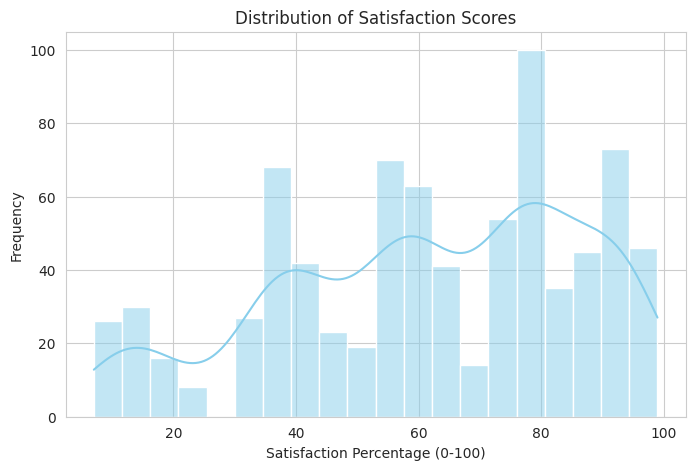

In [7]:
plt.figure(figsize=(8, 5))
sns.histplot(train_df['satisfaction_percentage'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Satisfaction Scores')
plt.xlabel('Satisfaction Percentage (0-100)')
plt.ylabel('Frequency')
plt.show()

Step 2.3: Text Length Analysis


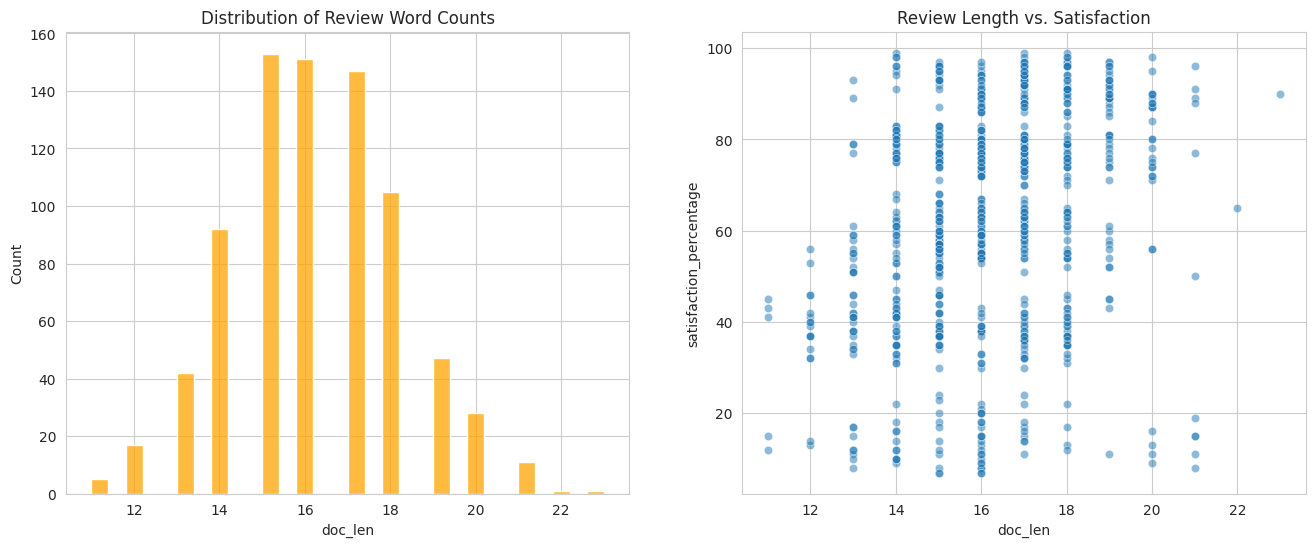

In [12]:
# Create a temporary length column for analysis
train_df['doc_len'] = train_df['comment'].apply(lambda x: len(str(x).split()))

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(train_df['doc_len'], bins=30, ax=ax[0], color='orange')
ax[0].set_title('Distribution of Review Word Counts')

sns.scatterplot(x='doc_len', y='satisfaction_percentage', data=train_df, alpha=0.5, ax=ax[1])
ax[1].set_title('Review Length vs. Satisfaction')

plt.show()

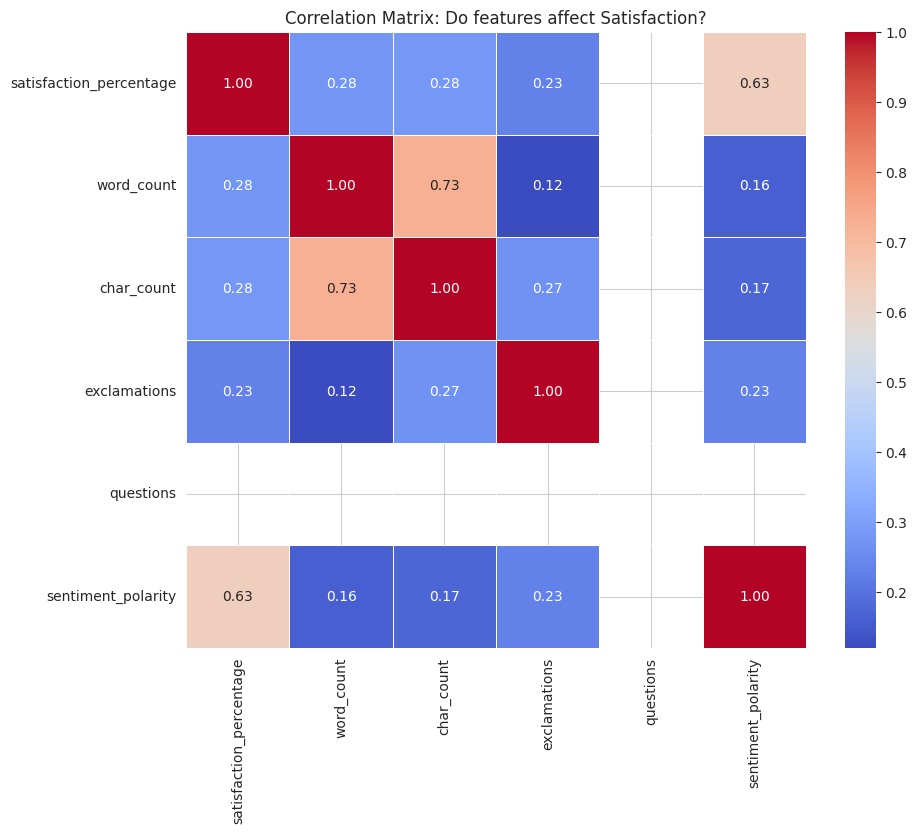

In [20]:
# Plot Heatmap
plt.figure(figsize=(10, 8))
# Correlation matrix
corr = eda_df[['satisfaction_percentage', 'word_count', 'char_count', 'exclamations', 'questions', 'sentiment_polarity']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix: Do features affect Satisfaction?")
plt.show()

 Feature Correlation Heatmap

In [15]:
from textblob import TextBlob

In [21]:
# we create numeric features for analysis
eda_df = train_df.copy()
eda_df['word_count'] = eda_df['comment'].apply(lambda x: len(str(x).split()))
eda_df['char_count'] = eda_df['comment'].apply(len)
eda_df['exclamations'] = eda_df['comment'].apply(lambda x: str(x).count('!'))
eda_df['questions'] = eda_df['comment'].apply(lambda x: str(x).count('?'))
eda_df['sentiment_polarity'] = eda_df['comment'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)


N-Gram Analysis

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(corpus, n=2, top_k=10):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_k]

# Split Data
positive_reviews = train_df[train_df['satisfaction_percentage'] > 75]['comment']
negative_reviews = train_df[train_df['satisfaction_percentage'] < 40]['comment']

# Get Bigrams
top_pos_bigrams = get_top_ngrams(positive_reviews, n=2)
top_neg_bigrams = get_top_ngrams(negative_reviews, n=2)


/tmp/ipython-input-2692427284.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(y_pos), y=list(x_pos), ax=ax[0], palette="Greens_d")
/tmp/ipython-input-2692427284.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(y_neg), y=list(x_neg), ax=ax[1], palette="Reds_d")


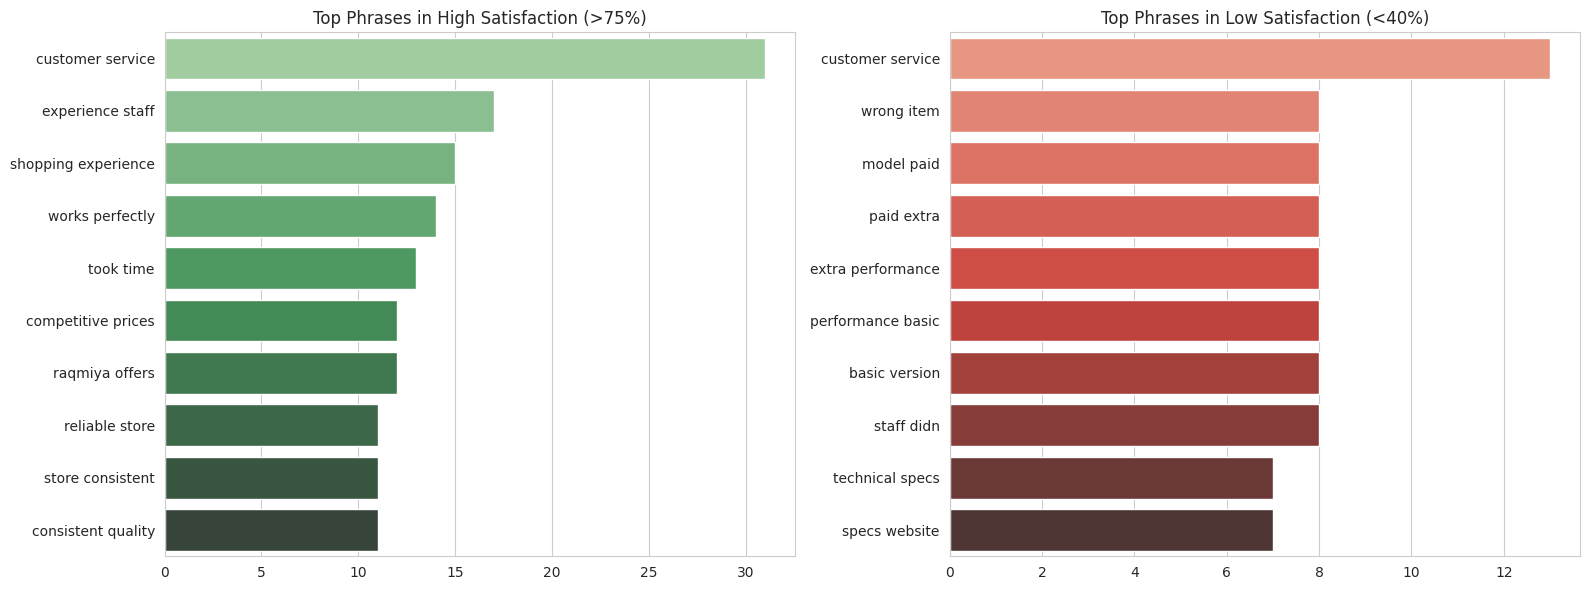

In [23]:
# Visualize
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot Positive
x_pos, y_pos = zip(*top_pos_bigrams)
sns.barplot(x=list(y_pos), y=list(x_pos), ax=ax[0], palette="Greens_d")
ax[0].set_title('Top Phrases in High Satisfaction (>75%)')

# Plot Negative
x_neg, y_neg = zip(*top_neg_bigrams)
sns.barplot(x=list(y_neg), y=list(x_neg), ax=ax[1], palette="Reds_d")
ax[1].set_title('Top Phrases in Low Satisfaction (<40%)')

plt.tight_layout()
plt.show()

Part of Speech Tagging Distribution

In [29]:
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

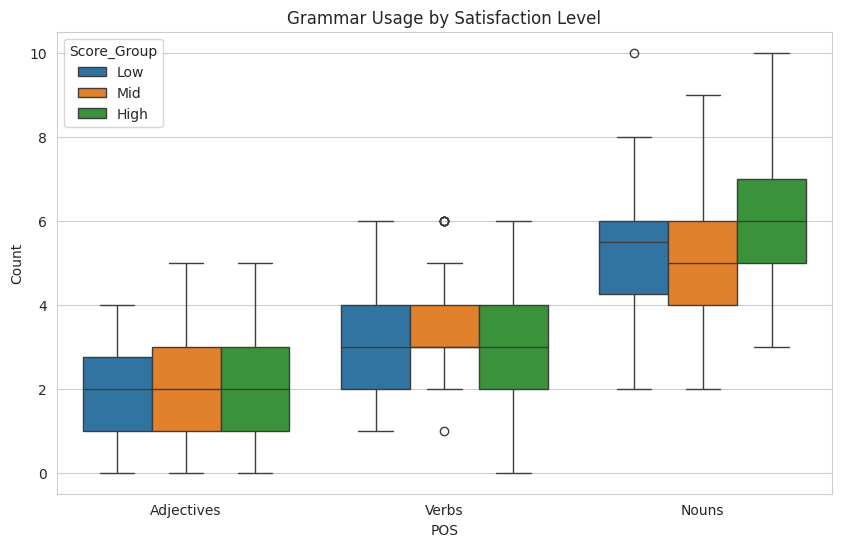

In [30]:
def count_tags(text):
    tokens = word_tokenize(text)
    tags = pos_tag(tokens)
    counts = {'Adjectives': 0, 'Verbs': 0, 'Nouns': 0}
    for word, tag in tags:
        if tag.startswith('JJ'): counts['Adjectives'] += 1
        elif tag.startswith('VB'): counts['Verbs'] += 1
        elif tag.startswith('NN'): counts['Nouns'] += 1
    return counts

# Apply to a sample to save time
sample_df = train_df.sample(200, random_state=42).copy()
pos_counts = sample_df['comment'].apply(lambda x: pd.Series(count_tags(x)))
sample_df = pd.concat([sample_df, pos_counts], axis=1)

# Categorize Score
sample_df['Score_Group'] = pd.cut(sample_df['satisfaction_percentage'], bins=[0, 40, 70, 100], labels=['Low', 'Mid', 'High'])

# Plot
pos_melt = sample_df.melt(id_vars=['Score_Group'], value_vars=['Adjectives', 'Verbs', 'Nouns'], var_name='POS', value_name='Count')

plt.figure(figsize=(10, 6))
sns.boxplot(x='POS', y='Count', hue='Score_Group', data=pos_melt)
plt.title("Grammar Usage by Satisfaction Level")
plt.show()

Named Entity Recognition

In [31]:
# Simple extraction of capitalized words in Negative Reviews
def extract_potential_entities(text):
    return re.findall(r'\b[A-Z][a-zA-Z0-9]+\b', text)

neg_entities = []
for comment in negative_reviews:
    neg_entities.extend(extract_potential_entities(comment))

# Filter out common start words like the a ..
common_stops = ['The', 'I', 'A', 'This', 'It', 'My']
neg_entities = [w for w in neg_entities if w not in common_stops]

from collections import Counter
print("Most Mentioned 'Entities' in Bad Reviews:")
print(Counter(neg_entities).most_common(10))

Most Mentioned 'Entities' in Bad Reviews:
[('Staff', 21), ('Raqmiya', 18), ('Customer', 12), ('Store', 11), ('Bought', 10), ('Paid', 10), ('CPU', 9), ('No', 8), ('SSD', 8), ('Disappointed', 8)]


Phase 3: Preprocessing Logic


In [32]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from textblob import TextBlob
from sklearn.base import BaseEstimator, TransformerMixin

class TextCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        data = pd.Series(X) if not isinstance(X, pd.Series) else X
        # Keep numbers because yhemouna
        return data.apply(lambda x: re.sub(r'[^a-zA-Z0-9\s!?]', '', str(x).lower()).strip())

class TextFeatureEngineering(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        data = pd.Series(X) if not isinstance(X, pd.Series) else X
        features = pd.DataFrame()

        # Clean temp version for stats
        cleaned = data.apply(lambda x: re.sub(r'[^a-zA-Z0-9\s!?]', '', str(x).lower()).strip())

        # Features
        features['char_count'] = cleaned.apply(len)
        features['word_count'] = cleaned.apply(lambda x: len(x.split()))
        features['exclamations'] = data.apply(lambda x: str(x).count('!'))

        # Sentiment
        features['polarity'] = cleaned.apply(lambda x: TextBlob(x).sentiment.polarity)
        features['subjectivity'] = cleaned.apply(lambda x: TextBlob(x).sentiment.subjectivity)

        # POS Tagging
        def get_pos(text):
            try:
                tokens = word_tokenize(text)
                if not tokens: return {'NN': 0, 'VB': 0, 'JJ': 0}
                tags = pos_tag(tokens)
                counts = {'NN': 0, 'VB': 0, 'JJ': 0}
                for word, tag in tags:
                    if tag.startswith('NN'): counts['NN'] += 1
                    elif tag.startswith('VB'): counts['VB'] += 1
                    elif tag.startswith('JJ'): counts['JJ'] += 1
                return counts
            except:
                return {'NN': 0, 'VB': 0, 'JJ': 0}

        pos_df = cleaned.apply(lambda x: pd.Series(get_pos(x)))
        features = pd.concat([features, pos_df], axis=1)

        return features.fillna(0)



In [34]:
# Verify the Engineering works
print("Testing Feature Engineering on first 3 rows:")
test_engineer = TextFeatureEngineering()
print(test_engineer.transform(train_df['comment'].head(3)))

Testing Feature Engineering on first 3 rows:
   char_count  word_count  exclamations  polarity  subjectivity  NN  VB  JJ
0         111          17             0       0.1      0.083333   5   2   4
1         106          16             0       0.0      0.000000   5   3   1
2         107          17             1       0.0      0.000000   9   0   3


In [36]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Define X and y
full_X = pd.concat([train_df['comment'], val_df['comment']], axis=0)
full_y = pd.concat([train_df['satisfaction_percentage'], val_df['satisfaction_percentage']], axis=0)

# Build the Pipe
text_pipe = Pipeline([
    ('cleaner', TextCleaner()),
    ('tfidf', TfidfVectorizer(max_features=2000, ngram_range=(1, 2)))
])

numeric_pipe = Pipeline([
    ('engineer', TextFeatureEngineering()),
    ('scaler', StandardScaler())
])

preprocessor = FeatureUnion([
    ('text', text_pipe),
    ('num', numeric_pipe)
])

# Import Models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Random Forest': RandomForestRegressor(n_estimators=50, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=50, random_state=42),
    'SVR': SVR(kernel='rbf')
}

# Run Comparison
results = {}
print("Running Cross-Validation...")
for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    # n_jobs=1 to avoid NLTK threading issues
    cv_scores = cross_val_score(pipe, full_X, full_y, cv=5, scoring='neg_mean_squared_error', n_jobs=1)
    rmse = np.sqrt(-cv_scores.mean())
    results[name] = rmse
    print(f"{name}: RMSE = {rmse:.4f}")


Running Cross-Validation...
Linear Regression: RMSE = 7.0905
Ridge: RMSE = 8.0265
Random Forest: RMSE = 6.9860
XGBoost: RMSE = 6.4378
SVR: RMSE = 19.2425


/tmp/ipython-input-4245090610.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.values()), y=list(results.keys()), palette='viridis')


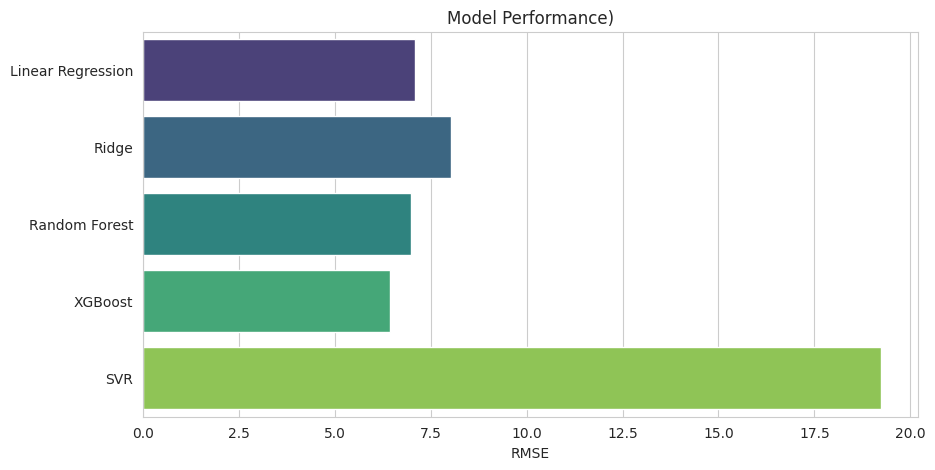

In [38]:
# Plot Comparison
plt.figure(figsize=(10, 5))
sns.barplot(x=list(results.values()), y=list(results.keys()), palette='viridis')
plt.title('Model Performance)')
plt.xlabel('RMSE')
plt.show()

Hyperparameter Tuning


In [39]:
from sklearn.model_selection import GridSearchCV

best_model_name = min(results, key=results.get)
print(f"Winning Model: {best_model_name}")


final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', SVR())
])

# Param
param_grid = {
    'model__C': [10, 50, 100],
    'model__epsilon': [0.1, 0.2, 0.5],
    'model__gamma': ['scale', 0.1]
}

print("Tuning Hyperparameters...")
grid_search = GridSearchCV(final_pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=1, verbose=1)
grid_search.fit(full_X, full_y)

print(f"Best Params: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

Winning Model: XGBoost
Tuning Hyperparameters...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Params: {'model__C': 100, 'model__epsilon': 0.5, 'model__gamma': 'scale'}


Final Evaluation


In [40]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# We predict on Test
X_test = test_df['comment']
y_test = test_df['satisfaction_percentage']
y_pred = best_model.predict(X_test)

# Metrics
print("\n--- Final Test Set Metrics ---")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"MAE:  {mean_absolute_error(y_test, y_pred):.4f}")
print(f"R2:   {r2_score(y_test, y_pred):.4f}")



--- Final Test Set Metrics ---
RMSE: 5.8173
MAE:  4.2930
R2:   0.9437


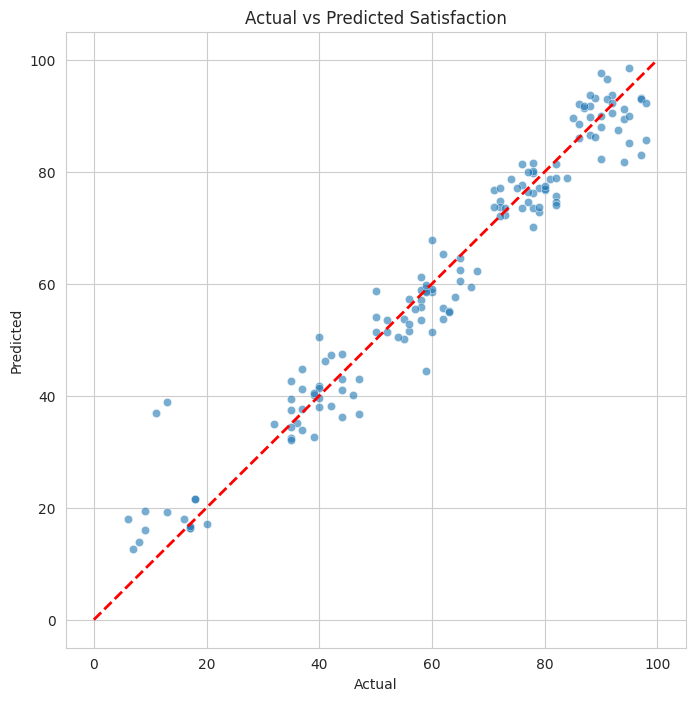

In [41]:
# Visualization
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([0, 100], [0, 100], '--r', linewidth=2) # Perfect prediction line
plt.title('Actual vs Predicted Satisfaction')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [43]:
# Error Analysis
test_df['predicted'] = y_pred
test_df['error'] = abs(test_df['satisfaction_percentage'] - test_df['predicted'])

print("\n--- Top 3 Biggest Errors ---")
for i, row in test_df.sort_values('error', ascending=False).head(3).iterrows():
    print(f"Comment: {row['comment']}")
    print(f"Actual: {row['satisfaction_percentage']} | Predicted: {row['predicted']:.2f}")
    print("-" * 50)


--- Top 3 Biggest Errors ---
Comment: Three weeks later and my keyboard and mouse combo repair still isn't done. Zero communication from the store.
Actual: 11 | Predicted: 36.95
--------------------------------------------------
Comment: Horrible quality mechanical keyboard. Stopped functioning immediately and return process was a nightmare.
Actual: 13 | Predicted: 38.80
--------------------------------------------------
Comment: The green screen meets basic expectations but doesn't exceed them. Installation instructions were unclear for game development setup.
Actual: 59 | Predicted: 44.43
--------------------------------------------------


Phase 7: Export


In [44]:
import shutil
import os
from google.colab import files

# Save Model
joblib.dump(best_model, 'satisfaction_model_pipeline.joblib')

# Zip & Download
zip_name = "satisfaction_model_final"
local_path = "./model_export"
if not os.path.exists(local_path): os.makedirs(local_path)

shutil.copy('satisfaction_model_pipeline.joblib', os.path.join(local_path, 'satisfaction_model_pipeline.joblib'))
shutil.make_archive(zip_name, 'zip', local_path)

print(f"Download ready for {zip_name}.zip")
files.download(f"{zip_name}.zip")

Download ready for satisfaction_model_final.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>